In [1]:
import sys
import time
import os
import random
import keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.cbook as cbook
import matplotlib.image as image


In [2]:
f = 3
C = 3

h = 225
l = 225

h_ = h-3+1;
l_ = l-3+1;

snapea_count = 0
original_count = 0
proposed_algo_count = 0

random.seed(10)
X = 2*np.random.randn(h,l)-1
W = np.random.randn(f,f)

def Sort_Tuple(tup):
    tup.sort(key = lambda x:x[2])
    return tup

def Sort_Tuple_Reverse(tup):
    tup.sort(key = lambda x:x[2], reverse=True)
    return tup

In [3]:
weights = []

for l1 in range(f):
    for l2 in range(f):
        weights.append((l1, l2, W[l1][l2]))

weights = Sort_Tuple(weights)

print(weights)

[(1, 0, -1.3570821996859401), (0, 1, -1.3518078433117264), (0, 0, -0.18481878579104155), (2, 1, -0.11383200861426508), (2, 2, 0.0604637376451255), (0, 2, 0.5757419437522199), (1, 2, 0.7001015259450675), (2, 0, 0.9605215665375647), (1, 1, 1.8432262098643248)]


SnaPEA Exact Mode

In [4]:
SnaPEA = np.zeros((h_,l_))
for i in range(0,h_):
    for j in range(0,l_):
        for iter in range(len(weights)):
                SnaPEA[i][j]+=(X[i+weights[iter][0]][j+weights[iter][1]]*weights[iter][2])
                snapea_count+=1
                if SnaPEA[i][j]<0:
                   SnaPEA[i][j]=0
                   break

Proposed Algorithm

In [5]:
pos = []
neg = []
    
for l1 in range(f):
    for l2 in range(f):
          if W[l1][l2]>0:
              pos.append((l1,l2,W[l1][l2]))
          else:
              neg.append((l1,l2,W[l1][l2]))

pos = Sort_Tuple_Reverse(pos)
neg = Sort_Tuple(neg)

print(pos)
print(neg)

lim = min(len(pos),len(neg))

[(1, 1, 1.8432262098643248), (2, 0, 0.9605215665375647), (1, 2, 0.7001015259450675), (0, 2, 0.5757419437522199), (2, 2, 0.0604637376451255)]
[(1, 0, -1.3570821996859401), (0, 1, -1.3518078433117264), (0, 0, -0.18481878579104155), (2, 1, -0.11383200861426508)]


In [6]:
Prop = np.zeros((h_,l_))
for i in range(0,h_,1):
    for j in range(0,l_,1):
        partial_sum = 0
        for iter in range(lim):
            partial_sum+=(pos[iter][2]*(X[i+pos[iter][0]][j+pos[iter][1]])) + (neg[iter][2]*(X[i+neg[iter][0]][j+neg[iter][1]]))
            Prop[i][j] = partial_sum
            proposed_algo_count += 1
            if partial_sum<0:
               Prop[i][j]=0
               break;    

Original 

In [7]:
Orig = np.zeros((h_,l_))
for i in range(0,h_):
    for j in range(0,l_):
        for r in range(f):
            for c in range(f):
                Orig[i][j]+=(X[i+r][j+c]*W[r][c])
                original_count+= 1
        if Orig[i][j]<0:
            Orig[i][j]=0
       
S_TP = 0
S_TN = 0
S_FP = 0
S_FN = 0

Pr_TP = 0
Pr_TN = 0
Pr_FP = 0
Pr_FN = 0

for i in range(0,h_):
    for j in range(0,l_):
        if Orig[i][j]==0:
          if SnaPEA[i][j]==0:
             S_TP += 1
          if SnaPEA[i][j]>0:
             S_FP += 1
          if Prop[i][j]==0:
             Pr_TP += 1
          if Prop[i][j]>0:
             Pr_FP += 1
        else:
          if SnaPEA[i][j]>0:
             S_TN += 1
          if SnaPEA[i][j]==0:
             S_FN += 1
          if Prop[i][j]>0:
             Pr_TN += 1
          if Prop[i][j]==0:
             Pr_FN += 1

Original


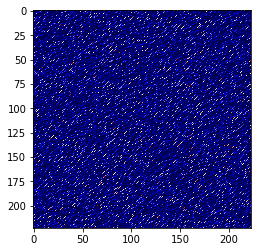

Proposed


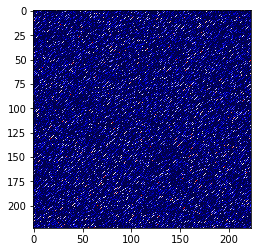

SnaPEA


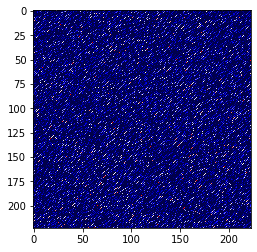

In [8]:
print("Original")
plt.imshow(Orig, cmap='seismic', interpolation='nearest')
plt.show()
print("Proposed")
plt.imshow(Prop, cmap='seismic', interpolation='nearest')
plt.show()
print("SnaPEA")
plt.imshow(SnaPEA, cmap='seismic', interpolation='nearest')
plt.show()

In [9]:
print("Snapea: ", snapea_count)
print("Proposed Algorithm: ", proposed_algo_count)
print("Original count: ", original_count)

Snapea:  283300
Proposed Algorithm:  108240
Original count:  447561


In [10]:
snapea_precision = S_TP/(S_TP + S_FP)
snapea_recall = S_TP/(S_TP + S_FN)

prop_precision = Pr_TP/(Pr_TP + Pr_FP)
prop_recall = Pr_TP/(Pr_TP + Pr_FN)

print("Snapea Precision : ", snapea_precision)
print("Snapea Recall : ", snapea_recall)

print("Proposed Algorithm Precision: ", prop_precision)
print("Proposed Algorithm Recall: ", prop_recall)

S_F1 = 2*(snapea_recall*snapea_precision)/(snapea_precision+snapea_recall)
Pr_F1 = 2*(prop_recall*prop_precision)/(prop_precision+prop_recall)

print("Snapea F1 Score: ", S_F1)
print("Proposed Algorithm F1 Score: ", Pr_F1)

Snapea Precision :  1.0
Snapea Recall :  0.8386917147797543
Proposed Algorithm Precision:  0.9962959080266974
Proposed Algorithm Recall:  0.8441450777202073
Snapea F1 Score:  0.9122700755522968
Proposed Algorithm F1 Score:  0.913931273240159
